In [ ]:
# !pip install transformers==3.0.0
# !pip install datasets
# !wget https://raw.githubusercontent.com/gorokoba560/norm-analysis-of-transformer/5dc8fb3b541f696288dec46fbd610d97a1a1ade2/emnlp2021/transformers/src/transformers/modeling_bert.py

## Setup

In [28]:
import torch
import numpy as np
# from modeling_bert import BertForSequenceClassification
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from datasets import load_dataset
from tqdm.notebook import tqdm
from importlib import reload
import pickle
import lzma
import yaml

SELECTED_GPU = 0
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:{}".format(SELECTED_GPU))
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(SELECTED_GPU))
else:
    device = "cpu"

ATTENTION_NORM_TYPES = {
#     "head_attn_n": 0,
    "N": 1,
    "N-Res": 2,
    "N-ResLN": 3,
    "N-Enc": 4
#     "attn_n_ratio": 5,
#     "attnres_n_ratio": 6,
#     "attnresln_n_ratio": 7
#     "N-Enc_ratio": 8
}

class FlowMethods:
    ROLLOUT = "rollout"
    MAX_FLOW = "maxflow"

with open('src/configs/experiments_config.yaml', "r") as f:
    config = yaml.safe_load(f)
    
### Editable:
config = config["SST2"]  # [SST2, MNLI, HATEXPLAIN] (Load different experiments config i.e. model, dataset and more)

config["FLOW_METHOD"] = FlowMethods.ROLLOUT
config["NUM_CPUS"] = 12  # If n<2 ? sequential : use p_map
config["OUTPUT_HIDDEN_STATES"] = False  # Default: True (Outputs flow up to each layer)
config["DATASET_SIZE_LIMIT"] = None  # Default: None (no limit)
config["DELETE_SEP"] = False  # Default: False (Visualizations will not work if set to True)

config["HTA_PATH"] = './HTA/sst2_val256_HTAxInput_undiv_FT_alllayers.npy'

config["MODEL_CHECKPOINT"] = "bert-base-uncased"

config

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


{'MODEL_CHECKPOINT': 'bert-base-uncased',
 'MODEL_NAME': 'bert-base-uncased',
 'DATASET': 'sst2',
 'SALIENCY_BLANK_OUT_PATH': './saliency/sst2_val_sals_normbased_selfFT.npy',
 'SALS_MAX_LENGTH': 64,
 'HTA_PATH': './HTA/sst2_val256_HTAxInput_undiv_FT_alllayers.npy',
 'FLOW_METHOD': 'rollout',
 'NUM_CPUS': 12,
 'OUTPUT_HIDDEN_STATES': False,
 'DATASET_SIZE_LIMIT': None,
 'DELETE_SEP': False}

## Model/Tokenizer/Dataset

In [29]:
import src.task_loaders
reload(src.task_loaders)

tokenizer = BertTokenizer.from_pretrained(config["MODEL_NAME"])
model = BertForSequenceClassification.from_pretrained(config["MODEL_CHECKPOINT"], local_files_only=False)
task_loader = src.task_loaders.TaskLoader(tokenizer, count=config["DATASET_SIZE_LIMIT"], 
                                          max_length=config["SALS_MAX_LENGTH"])

dataset, encoder_func = task_loader.load_task(config["DATASET"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Extract Attentions

In [30]:
import src.model_attentions
reload(src.model_attentions)

raw_attentions, norms_list = src.model_attentions.extract_attentions(model, encoder_func, len(dataset), device, 
                                                                     config["DELETE_SEP"])
print(raw_attentions[-1].shape, norms_list[3][-1].shape)

  0%|          | 0/872 [00:00<?, ?it/s]

(12, 31, 31) (12, 31, 31)


In [31]:
norms_list[6][250].shape

(12, 17)

In [52]:
### Ratio Mean in Layers
for layer in range(12):
    layer_ratios = np.array([np.mean(norm[layer]) for norm in norms_list[6]])
#     print(layer_ratios.shape)
    print(f"{layer}".ljust(4), f"{np.mean(layer_ratios):.2f}", f"± {np.std(layer_ratios):.2f}")

0    0.31 ± 0.01
1    0.26 ± 0.01
2    0.26 ± 0.01
3    0.25 ± 0.01
4    0.24 ± 0.01
5    0.23 ± 0.02
6    0.24 ± 0.02
7    0.23 ± 0.02
8    0.22 ± 0.01
9    0.24 ± 0.01
10   0.20 ± 0.02
11   0.17 ± 0.02


In [53]:
import src.model_attentions
reload(src.model_attentions)

r_ratio_attentions = src.model_attentions.build_ratio_residual_attentions(raw_attentions, norms_list)

local_attentions = {"W": raw_attentions}
for key, attention_mat in r_ratio_attentions.items():
    local_attentions[key] = attention_mat
for key, value in ATTENTION_NORM_TYPES.items():
    local_attentions[key] = norms_list[value]

## ADD LOCAL HTA
hta = np.load(config["HTA_PATH"])
local_attentions["HTA"] = []
for i in range(hta.shape[1]):
    length = min(len(local_attentions["W"][i][0]), len(hta[0][i]))
    local_attentions["HTA"].append(hta[:, i, :length, :length])
    
local_attentions.keys()
local_attentions["W"][1].shape

  0%|          | 0/872 [00:00<?, ?it/s]

(12, 10, 10)

## Compute Attention Rollout/MaxFlow

In [9]:
import src.attention_flow_abstract
reload(src.attention_flow_abstract)
import src.attention_rollout
reload(src.attention_rollout)
import src.attention_max_flow
reload(src.attention_max_flow)

flow_class = src.attention_rollout.AttentionRollout() if config["FLOW_METHOD"] == FlowMethods.ROLLOUT else src.attention_max_flow.AttentionMaxFlow()
flow_function = flow_class.compute_flows
print(flow_function)

attention_flows = dict()

for key, local_attention in local_attentions.items():
    layer_swap_flow = []
    for layer in range(12):
        swapped_maps = [np.copy(att_map) for att_map in local_attentions["HTA"]]
        for i in range(len(swapped_maps)):
            swapped_maps[i][:layer] = local_attention[i][:layer]  # SWAP
            
        layer_swap_flow.append(flow_function(swapped_maps,
                                             desc=f"{key} swapped layer {layer}".ljust(12, '_'),
                                             output_hidden_states = config["OUTPUT_HIDDEN_STATES"],
                                             num_cpus=config["NUM_CPUS"]))
    attention_flows[key] = []
    for i in range(len(layer_swap_flow[0])):
        attention_flows[key].append(np.array([np.squeeze(layer_swap_flow[layer][i]) for layer in range(12)]))

# file_name = f"{DATASET}_{MODEL_CHECKPOINT.split('/')[-1]}_{FLOW_METHOD}.pickle_lzma"
# with lzma.open(file_name, 'wb') as f:
#     print("Saving...")
#     pickle.dump(attention_flows, f, protocol=pickle.HIGHEST_PROTOCOL)
#     print(f"Saved attentions to [{file_name}]")
    
print(attention_flows.keys(), attention_flows["N"][-1].shape)

<bound method AttentionRollout.compute_flows of <src.attention_rollout.AttentionRollout object at 0x000002601A0D0780>>


W swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

W swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

N swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 0:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 1:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 2:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 3:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 4:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 5:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 6:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 7:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 8:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 9:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 10:   0%|          | 0/256 [00:00<?, ?it/s]

HTA swapped layer 11:   0%|          | 0/256 [00:00<?, ?it/s]

dict_keys(['W', 'W-FixedRes', 'W-Res', 'N-FixedRes', 'N', 'N-Res', 'N-ResLN', 'N-Enc', 'HTA']) (12, 25, 25)


## Compute Metrics (Compare to saliency)

### Flow Correlation

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import src.metrics
reload(src.metrics)

# spearmans_raw_flow = src.metrics.compute_spearman_correlation(raw_attentions_rollouts, 
#                                                          SALIENCY_BLANK_OUT_PATH)

spearmans = dict()  # spearmans[key]: (#batch, #layers, spearman)
for key in attention_flows.keys():
    spearmans[key] = src.metrics.compute_spearman_correlation(attention_flows[key], 
                                                              config["SALIENCY_BLANK_OUT_PATH"],
                                                              aggregation="CLS",
                                                              desc=key.ljust(12, '_'),
                                                              max_length=config["SALS_MAX_LENGTH"])


# PRINT
for key in spearmans.keys():
    spearman = np.array(spearmans[key])
    max_layer = np.argmax(np.mean(spearman, axis=0))
#     print(f"Max Layer: {max_layer+1}", f"{key}", f"{np.mean(spearman[:, max_layer]):.2f}", f"± {np.std(spearman[:, max_layer]):.2f}")
    layers = spearmans[key][0].shape[0]
    for layer in range(layers):
        spearman = np.array(spearmans[key])[:, layer]
        layer_text = f"-L{layer+1}" if layers > 1 else ""
        print(f"{key}{layer_text}".ljust(23), f"{np.mean(spearman):.2f}", f"± {np.std(spearman):.2f}")

W___________:   0%|          | 0/256 [00:00<?, ?it/s]

W-FixedRes__:   0%|          | 0/256 [00:00<?, ?it/s]

W-Res_______:   0%|          | 0/256 [00:00<?, ?it/s]

N-FixedRes__:   0%|          | 0/256 [00:00<?, ?it/s]

N___________:   0%|          | 0/256 [00:00<?, ?it/s]

N-Res_______:   0%|          | 0/256 [00:00<?, ?it/s]

N-ResLN_____:   0%|          | 0/256 [00:00<?, ?it/s]

N-Enc_______:   0%|          | 0/256 [00:00<?, ?it/s]

HTA_________:   0%|          | 0/256 [00:00<?, ?it/s]

W-L1                    0.80 ± 0.10
W-L2                    0.54 ± 0.19
W-L3                    0.02 ± 0.25
W-L4                    -0.04 ± 0.24
W-L5                    -0.07 ± 0.24
W-L6                    -0.09 ± 0.24
W-L7                    -0.09 ± 0.24
W-L8                    -0.09 ± 0.24
W-L9                    -0.10 ± 0.24
W-L10                   -0.10 ± 0.24
W-L11                   -0.10 ± 0.24
W-L12                   -0.10 ± 0.24
W-FixedRes-L1           0.80 ± 0.10
W-FixedRes-L2           0.61 ± 0.15
W-FixedRes-L3           0.33 ± 0.23
W-FixedRes-L4           0.12 ± 0.26
W-FixedRes-L5           -0.01 ± 0.27
W-FixedRes-L6           -0.11 ± 0.27
W-FixedRes-L7           -0.16 ± 0.26
W-FixedRes-L8           -0.18 ± 0.26
W-FixedRes-L9           -0.20 ± 0.26
W-FixedRes-L10          -0.21 ± 0.26
W-FixedRes-L11          -0.22 ± 0.26
W-FixedRes-L12          -0.22 ± 0.25
W-Res-L1                0.80 ± 0.10
W-Res-L2                0.60 ± 0.16
W-Res-L3                0.54 ± 0.18
W-Res-L4   

16.0
16.0
16.0
16.0
16.0
16.0


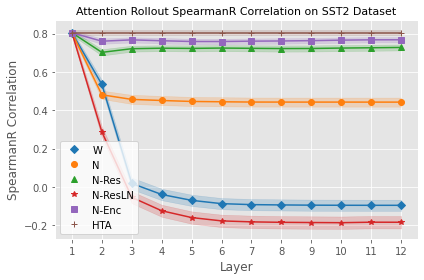

In [20]:
# PLOT
fig = plt.figure(figsize=(6, 4))
cmap = plt.get_cmap("tab10")
markers = ['D', 'o', '^', '*', 's', '+', 'x', '.', 'X']
c = 0
for key in spearmans.keys():
    if key in ["W-Res", "W-FixedRes", "N-FixedRes"]:
        continue
    layers = spearmans[key][0].shape[0]
    spearman = np.array(spearmans[key])
    print(np.sqrt(len(spearman)))
    with plt.style.context("ggplot"):
        x = range(1, layers + 1)
        plt.plot(x, np.mean(spearman, axis=0), markers[c], label=key, color=cmap(c))
        plt.plot(x, np.mean(spearman, axis=0), color=cmap(c))
        plt.fill_between(x, 
                         np.mean(spearman, axis=0) - np.std(spearman, axis=0) * 1.96 / np.sqrt(len(spearman)), 
                         np.mean(spearman, axis=0) + np.std(spearman, axis=0) * 1.96 / np.sqrt(len(spearman)),
                         alpha=0.2, color=cmap(c))
        plt.xticks(x)
        
    c += 1
plt.legend(loc="lower left")
dataset_name_map = {"sst2": "SST2", "mnli": "MNLI", "hatexplain": "HATEXPLAIN"}
plt.title(f"Attention Rollout SpearmanR Correlation on {dataset_name_map[config['DATASET']]} Dataset", fontsize=11)
plt.ylabel("SpearmanR Correlation")
plt.xlabel("Layer")
fig.tight_layout()
# filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
file_name = f"{config['DATASET']}_HTA_swap_beginning_95.pdf"
fig.savefig(file_name, dpi=50)

### Single Layers Correlation

raw 0_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 0___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 0_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 0_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 0_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 1_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 1___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 1_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 1_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 1_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 2_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 2___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 2_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 2_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 2_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 3_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 3___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 3_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 3_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 3_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 4_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 4___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 4_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 4_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 4_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 5_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 5___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 5_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 5_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 5_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 6_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 6___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 6_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 6_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 6_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 7_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 7___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 7_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 7_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 7_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 8_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 8___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 8_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 8_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 8_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 9_________:   0%|          | 0/872 [00:00<?, ?it/s]

N 9___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 9_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 9_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 9_______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 10________:   0%|          | 0/872 [00:00<?, ?it/s]

N 10__________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 10______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 10____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 10______:   0%|          | 0/872 [00:00<?, ?it/s]

raw 11________:   0%|          | 0/872 [00:00<?, ?it/s]

N 11__________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 11______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 11____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 11______:   0%|          | 0/872 [00:00<?, ?it/s]

Max Layer: 5 raw 0.31 ± 0.23
1 raw          -0.52 ± 0.17
2 raw          -0.40 ± 0.22
3 raw          -0.16 ± 0.26
4 raw          0.12 ± 0.26
5 raw          0.31 ± 0.23
6 raw          0.17 ± 0.25
7 raw          0.11 ± 0.25
8 raw          0.12 ± 0.25
9 raw          0.08 ± 0.23
10 raw         0.14 ± 0.23
11 raw         0.05 ± 0.24
12 raw         0.14 ± 0.25
Max Layer: 5 N 0.41 ± 0.21
1 N            -0.50 ± 0.18
2 N            -0.33 ± 0.23
3 N            0.11 ± 0.26
4 N            0.38 ± 0.21
5 N            0.41 ± 0.21
6 N            0.28 ± 0.23
7 N            0.17 ± 0.24
8 N            0.21 ± 0.23
9 N            0.18 ± 0.23
10 N           0.26 ± 0.22
11 N           0.27 ± 0.22
12 N           0.40 ± 0.21
Max Layer: 12 N-Res 0.41 ± 0.19
1 N-Res        -0.48 ± 0.18
2 N-Res        -0.33 ± 0.23
3 N-Res        0.11 ± 0.26
4 N-Res        0.38 ± 0.21
5 N-Res        0.41 ± 0.21
6 N-Res        0.29 ± 0.24
7 N-Res        0.21 ± 0.24
8 N-Res        0.23 ± 0.23
9 N-Res        0.22 ± 0.23
10 N-Res      

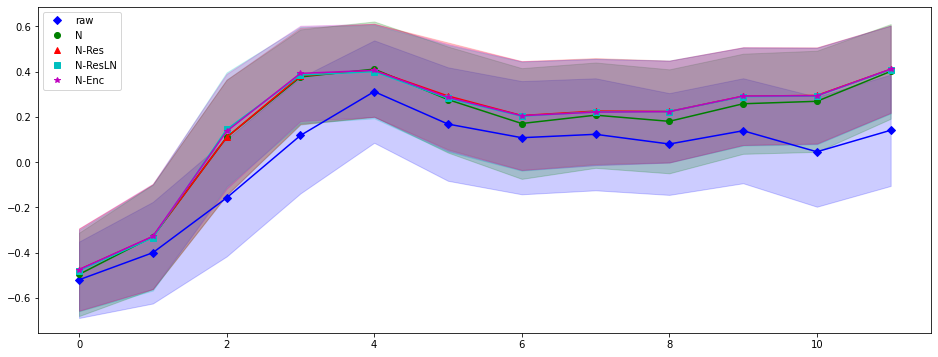

In [70]:
import src.metrics
reload(src.metrics)

spearmans_attentions = dict()
spearmans_attentions["raw"] = []
for key, value in ATTENTION_NORM_TYPES.items():
    spearmans_attentions[key] = []

for layer in range(12):
    spearmans_attentions["raw"].append(src.metrics.compute_spearman_correlation([r[layer] for r in raw_attentions], 
                                                                                config["SALIENCY_BLANK_OUT_PATH"],
                                                                                desc=f"raw {layer}".ljust(14, '_'),
                                                                                max_length=config["SALS_MAX_LENGTH"]))
    
    for key, value in ATTENTION_NORM_TYPES.items():
        spearmans_attentions[key].append(src.metrics.compute_spearman_correlation([n[layer] for n in norms_list[value]], 
                                                                                  config["SALIENCY_BLANK_OUT_PATH"],
                                                                                  desc=f"{key} {layer}".ljust(14, '_'),
                                                                                  max_length=config["SALS_MAX_LENGTH"]))
#PRINT
for key, value in spearmans_attentions.items():
    spearmans = np.array(spearmans_attentions[key])
    max_layer = np.argmax(np.mean(spearmans_attentions[key], axis=1))
    print(f"Max Layer: {max_layer+1}", f"{key}", f"{np.mean(spearmans_attentions[key][max_layer]):.2f}", f"± {np.std(spearmans_attentions[key][max_layer]):.2f}")
    for layer in range(12):
        print(f"{layer+1} {key}".ljust(14), 
              f"{np.mean(spearmans_attentions[key][layer]):.2f}",
              f"± {np.std(spearmans_attentions[key][layer]):.2f}")

# PLOT
plt.figure(figsize=(16, 6))
colors = ["b", "g", "r", "c", "m"]
markers = ['D', 'o', '^', 's', '*']
c = 0
for key, value in spearmans_attentions.items():
    y_mean = []
    y_std = []
    for layer in range(12):
        y_mean.append(np.mean(spearmans_attentions[key][layer]))
        y_std.append(np.std(spearmans_attentions[key][layer]))
    y_mean = np.array(y_mean)
    y_std = np.array(y_std)
    plt.plot(range(12), y_mean, markers[c], label=key, color=colors[c])
    plt.plot(range(12), y_mean, color=colors[c])
    plt.fill_between(range(12), 
                     y_mean - y_std, 
                     y_mean + y_std,
                     alpha=0.2, color=colors[c])
    c += 1
plt.legend(loc="upper left")

## Visualization

In [82]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_heatmap(norm, tokenized_text, title=""):
    df = pd.DataFrame(norm, columns=tokenized_text, index=tokenized_text)
    sns.heatmap(df,cmap="Reds",square=True)
    plt.title(title)
    plt.gcf().subplots_adjust(bottom=0.2)

### Attention Flow

C:\Users\Mohsen\Anaconda3\envs\attention-env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Mohsen\Anaconda3\envs\attention-env\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Mohsen\Anaconda3\envs\attention-env\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


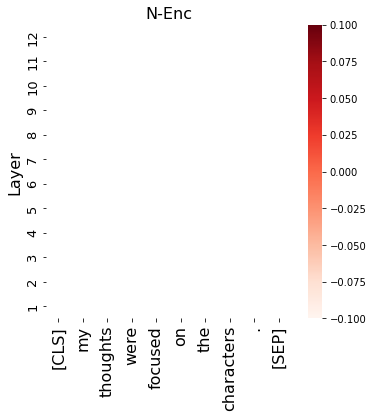

In [87]:
### 12 Layers in One (Just CLS)
import matplotlib.backends.backend_pdf

def plot_flow_heatmaps_cls(idx, specific_method=None):
    encoded = encoder_func(idx)
    tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    if specific_method is None:
        plt.figure(figsize=(22, 17))
    else:
        plt.figure(figsize=(6, 6))
    c = 1
    for key in attention_flows.keys():
        # N-Enc, N-Res
        if specific_method is not None and key != specific_method:
            continue
        if specific_method is None:
            plt.subplot(2, 4, c)
            c += 1
        else:
            plt.subplot(1, 1, c)
        norm_cls = attention_flows[key][idx][:, 0, :]
        norm_cls = np.flip(norm_cls, axis=0)
        row_sums = norm_cls.max(axis=1)
        norm_cls = norm_cls / row_sums[:, np.newaxis]
        
        df = pd.DataFrame(norm_cls, columns=tokenized_text, index=range(12, 0, -1))
        sns.heatmap(df,cmap="Reds",square=True)
        plt.title(key, fontsize=16)
        plt.ylabel("Layer", fontsize=16)
        plt.xticks(rotation = 90, fontsize=16)
        plt.yticks(fontsize=13)
        plt.gcf().subplots_adjust(bottom=0.2)
        
# 320, 493, 599, 746
idx = 195
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{config['DATASET']}_{idx}_rollout_cls.pdf")
plot_flow_heatmaps_cls(idx, specific_method="N-Enc")
# plot_flow_heatmaps_cls(idx, specific_method=None)
fig.tight_layout()
plt.savefig(pdf, format='pdf')
pdf.close()


# for i in range(800):
#     test_idx = i
#     encoded = encoder_func(test_idx)
#     tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
#     if 5 < len(tokenized_text) < 12 and "#" not in "".join(tokenized_text):
#         print("idx =", i)
#         plot_flow_heatmaps_cls(test_idx, specific_method="N-Res")
#         plt.show()

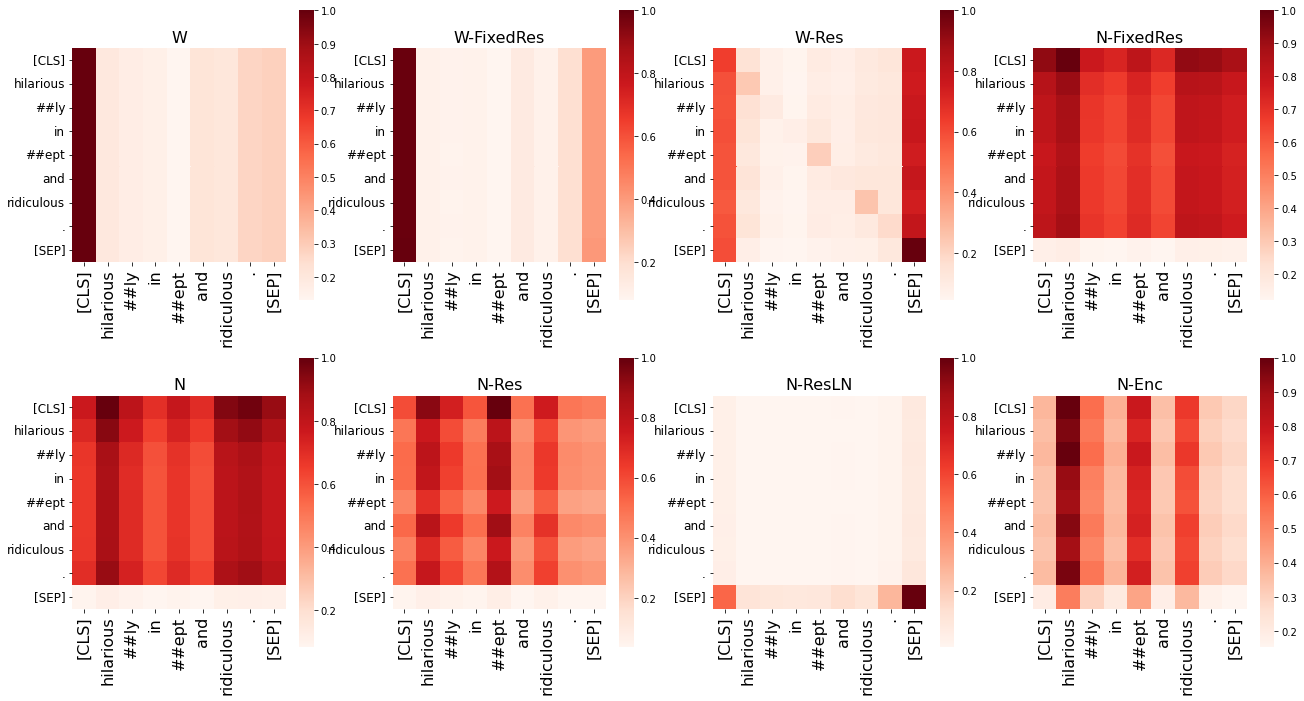

In [14]:
import matplotlib.backends.backend_pdf

def plot_flow_heatmaps(idx, layer=-1):
    encoded = encoder_func(idx)
    tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    plt.figure(figsize=(22, 13))
    c = 1
    for key in attention_flows.keys():
        plt.subplot(2, 4, c)
        c += 1
        norm = attention_flows[key][idx][layer] / np.max(attention_flows[key][idx][layer])
        plot_heatmap(norm, tokenized_text, key)
        plt.xticks(rotation = 90, fontsize=16)
        plt.title(key, fontsize=16)
        plt.yticks(rotation = 0, fontsize=16)
        plt.yticks(fontsize=12)
        

# for i in range(800):
#     test_idx = i
#     encoded = encoder_func(test_idx)
#     tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
#     if 2 < len(tokenized_text) < 5:
#         print("idx =", i)
#         plot_flow_heatmaps(test_idx)
#         plt.show()

pdf = matplotlib.backends.backend_pdf.PdfPages(f"{config['DATASET']}_{idx}_rollout12_tokens.pdf")
plot_flow_heatmaps(idx=112)
fig.tight_layout()
plt.savefig(pdf, format='pdf')
pdf.close()

# pdf = matplotlib.backends.backend_pdf.PdfPages(f"{config['DATASET']}_flow_aggregate_layers.pdf")
# for layer in range(len(attention_flows["W"][0])):
#     plot_flow_heatmaps(idx=32, layer=layer)
#     plt.suptitle(f"Layer {layer}", fontsize=12)
#     plt.savefig(pdf, format='pdf')
# pdf.close()

In [ ]:
# attention_flows["attnresln_n"][0][-1]/1e19

### Attention in single layers (w/o flow)

In [ ]:
import matplotlib.backends.backend_pdf

def plot_layers_heatmap(idx, layer):
    encoded = encoder_func(idx)
    tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    plt.figure(figsize=(25, 6))
    # Plot Raw Attention
    plt.subplot(1, 4, 1)
    norm = raw_attentions[idx][layer]
    plot_heatmap(norm, tokenized_text, "Attn-W")
    # Plot Norm Attentions
    c = 2
    for key, value in ATTENTION_NORM_TYPES.items():
        plt.subplot(1, 4, c)
        c += 1
        norm = norms_list[value][idx][layer]
        plot_heatmap(norm, tokenized_text, key)

test_idx = 32
pdf = matplotlib.backends.backend_pdf.PdfPages("layers.pdf")
for layer in range(12):
    plot_layers_heatmap(test_idx, layer)
    plt.suptitle(f"Layer {layer}", fontsize=12)
    plt.savefig(pdf, format='pdf')
pdf.close()